In [1]:
'''
=====Experiment=====
DONE
'''
DATASET_NAME = "BoT_IoT"

GRAPH_CONSTRUCTION = 'endpoint'
WINDOW_SIZE = 750

MULTICLASS = True

LOAD_SAVED = False

FIRST_RUN = not LOAD_SAVED

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config as Dataset_Config

EXPERIMENT_NAME = f"strat_window_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}"

SOURCE_IP_COL_NAME = Dataset_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = Dataset_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = Dataset_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = Dataset_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = Dataset_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = Dataset_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = Dataset_Config.BENIGN_CLASS_NAME

TIME_COLS = Dataset_Config.TIME_COL_NAMES

DROP_COLS = Dataset_Config.DROP_COLS

COLS_TO_NORM = Dataset_Config.COLS_TO_NORM
CATEGORICAL_COLS = Dataset_Config.CATEGORICAL_COLS

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
else:
    label_col = IS_ATTACK_COL_NAME

save_path = os.path.join(project_root, f"Models/E_GraphSAGE/{DATASET_NAME}/saved", EXPERIMENT_NAME)

checkpoint_path = os.path.join(save_path, f"checkpoints.pth")
best_model_path = os.path.join(save_path, f"best_model.pth")

os.makedirs(save_path, exist_ok=True)


In [2]:
if FIRST_RUN:
    csv_file_name = "all_raw"

    data = pd.read_csv(os.path.join(project_root, "Datasets", f"{DATASET_NAME}/All/{csv_file_name}.csv"))

In [3]:
if FIRST_RUN:
    print(data[ATTACK_CLASS_COL_NAME].value_counts())
    print(data[IS_ATTACK_COL_NAME].value_counts())

    if MULTICLASS:
        data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
    else:
        data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [4]:
if FIRST_RUN:
    data.drop(columns=DROP_COLS,inplace=True)
    print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [5]:
if FIRST_RUN:
    if GRAPH_CONSTRUCTION == 'endpoint':
        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

        # # Combine Port and IP
        data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
        data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
        data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]

    elif GRAPH_CONSTRUCTION == 'host':
        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]
        COLS_TO_NORM = COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
    else:
        raise ValueError("Invalid GRAPH_CONSTRUCTION value. Use 'host' or 'endpoint'.")
    

In [6]:
if FIRST_RUN:
    # Clean NaN values
    data.reset_index(drop=True, inplace=True)
    data.replace([np.inf, -np.inf], np.nan,inplace = True)
    data.fillna(0,inplace = True)

In [7]:
if not LOAD_SAVED:
    # Normalize numerical columns
    scaler = StandardScaler()
    print(data[COLS_TO_NORM].describe()) # Check if there's any too large value

    # Check for numeric issues in the columns before normalization
    def check_numeric_issues(df, cols_to_norm):
        for col in cols_to_norm:
            try:
                # Try to coerce to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            except Exception as e:
                print(f"❌ Column '{col}' failed with error: {e}")
                print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
                print(f"  - Data type: {df[col].dtype}")
                continue

        print("\n✅ All other columns processed successfully.")

    check_numeric_issues(data, COLS_TO_NORM)

    data[COLS_TO_NORM] = scaler.fit_transform(data[COLS_TO_NORM])

    # Save the scaler for future use
    scaler_path = os.path.join(save_path, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print("Data after normalization:")

               pkts         bytes           dur          mean        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.725963e+00  8.690501e+02  2.033479e+01  2.231063e+00  8.871499e-01   
std    1.155876e+02  1.122667e+05  2.148764e+01  1.517728e+00  8.037139e-01   
min    1.000000e+00  6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.200000e+02  1.256256e+01  1.819670e-01  3.001900e-02   
50%    7.000000e+00  6.000000e+02  1.550852e+01  2.690125e+00  7.938960e-01   
75%    9.000000e+00  7.700000e+02  2.709986e+01  3.565203e+00  1.745296e+00   
max    7.005700e+04  7.183334e+07  2.771485e+03  4.981882e+00  2.496763e+00   

                sum           min           max         spkts         dpkts  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.721635e+00  1.017540e+00  3.020015e+00  7.314146e+00  4.118173e-01   
std    7.616199e+00  1.483688e+00  1.860877e+00  7.

In [8]:
if LOAD_SAVED:
    # load scaler
    scaler_path = os.path.join(save_path, "scaler.pkl")
    scaler = joblib.load(scaler_path)

In [9]:
if FIRST_RUN:
    num_classes = 2
    class_map = [0, 1]
    if MULTICLASS:
        le = LabelEncoder()
        attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
        class_map = le.classes_
        print(class_map)
        print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
        data[ATTACK_CLASS_COL_NAME] = attack_labels
        num_classes = len(class_map)
        class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    joblib.dump(le, labeller_path)
    joblib.dump(class_map, class_map_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [10]:
if LOAD_SAVED:
    # Save the class map BENIGN_CLASS_LABEL, ADVERSARIAL_CLASS_LABEL
    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    class_map = joblib.load(class_map_path)
    le = joblib.load(labeller_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

In [11]:
if not LOAD_SAVED:
    # Maintain the order of the rows in the original dataframe
    feature_cols = COLS_TO_NORM + converted_categorical_cols

    print('Feature Columns:', feature_cols)
    num_features = len(feature_cols)
    print('Number of Features:', num_features)

    data['h'] = data[ feature_cols ].values.tolist()
    print(data.head(5))

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of Features: 54
   pkSeqID         stime                saddr                daddr  \
0  3576925  1.526344e+09     19

In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    assert num_edges == G_nx.number_of_edges(), "Number of edges in PyG graph does not match NetworkX graph."

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

In [14]:
if FIRST_RUN:
    def generate_graph_datasets(
        df: pd.DataFrame, 
        window_size: int = WINDOW_SIZE, 
        feature_cols=feature_cols,
        ordering_cols= TIME_COLS, 
        label_col=label_col,
        build_graph_func=create_graph,
        ):

        print("All Columns: ", df.columns)
        print("Ordering Columns: ", ordering_cols)
        assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
        assert label_col in df.columns, "Edge label column 'label' is required"
        
        df = df.sort_values(ordering_cols).reset_index(drop=True)
        window_size = int(window_size)
        
        df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

        print("Final Columns: ", df.columns)
        
        label_counts_list = []
        X = []
        y = []

        progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
        for start in progress_bar:
            window_df = df[start: min(start + window_size, len(df))]
            contains_label = window_df[label_col].unique()

            G_pyg = build_graph_func(window_df)

            label_counts = window_df[label_col].value_counts()

            label_counts_list.append(label_counts)
            X.append(G_pyg)
            y.append(contains_label.tolist())

        return StratifiedGraphDataset(X, y)

In [15]:
test_graph_dataset_path = os.path.join(save_path, "test_graph_dataset.pth")
if FIRST_RUN:
    graph_dataset = generate_graph_datasets(data)
    full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)
    th.save(test_graph_dataset, test_graph_dataset_path)

if LOAD_SAVED:
    # Save or Load test_graph_dataset
    if os.path.exists(test_graph_dataset_path):  
        test_graph_dataset = th.load(test_graph_dataset_path, weights_only=False)
    else:       
        raise FileNotFoundError(f"File {test_graph_dataset_path} does not exist. Please run the code to generate the dataset first.")
    

All Columns:  Index(['pkSeqID', 'stime', 'saddr', 'daddr', 'pkts', 'bytes', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3',
       'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7',
       'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2',
       'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6',
       'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10',
       'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3',
       'proto_

Generating graphs: 100%|██████████| 4892/4892 [03:04<00:00, 26.45it/s]


In [16]:
if FIRST_RUN:
    print("Class Distrubution:", data[label_col].value_counts())

    print("Number of graphs after downsampling:", len(graph_dataset))
    graph_dataset.print_class_distribution_and_weights()

    print("Number of training graphs:", len(full_train_graph_dataset))
    full_train_graph_dataset.print_class_distribution_and_weights()

    print("Number of testing graphs:", len(test_graph_dataset))
    test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: category
0    1926624
1    1650260
3      91082
2        477
4         79
Name: count, dtype: int64
Number of graphs after downsampling: 4892
Class Counts and Weights:
2   Normal         : Count = 477       , Weight = 1538.1644 
3   Reconnaissance : Count = 91082     , Weight = 8.0554    
1   DoS            : Count = 1650260   , Weight = 0.4446    
0   DDoS           : Count = 1926624   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 9287.3975 
Number of training graphs: 4159
Class Counts and Weights:
2   Normal         : Count = 299       , Weight = 2086.1351 
3   Reconnaissance : Count = 77760     , Weight = 8.0215    
1   DoS            : Count = 1403191   , Weight = 0.4445    
0   DDoS           : Count = 1637443   , Weight = 0.3809    
4   Theft          : Count = 79        , Weight = 7895.6253 
Number of testing graphs: 733
Class Counts and Weights:
3   Reconnaissance : Count = 13322     , Weight = 10.3166   
2   Normal         : Count 

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [21]:
from sklearn.metrics import f1_score

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()


In [22]:
if FIRST_RUN:
    def grid_search(graph_dataset, patience, max_epochs, learning_rates, hidden_dims, drop_outs, folds=3):
        global num_features
        
        best_params = {}
        best_f1 = 0
        params_results = {}

        # Precompute the train and validation graphs for all folds
        folds_list = []
        for i in range(folds):
            train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
            folds_list.append((train_graph_dataset, val_graph_dataset))

        for lr in learning_rates:
            for hidden_dim in hidden_dims:
                for drop_out in drop_outs:
                    print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                    fold_f1_scores = []

                    for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                        print(f"Fold {fold + 1}")

                        model = EGraphSAGE(node_in_channels=num_features,
                                        edge_in_channels=num_features,
                                        hidden_channels=hidden_dim,
                                        dropout = drop_out,
                                        out_channels=num_classes).to(device)

                        model.apply(init_weights)

                        # Normalize to stabilize training
                        class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                        print("Class weights:", class_weights)

                        criterion = nn.CrossEntropyLoss(weight=class_weights)
                        optimizer = th.optim.Adam(model.parameters(), lr=lr)
                        scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode='min',
                            factor=0.6,
                            patience=5,
                            min_lr=1e-6,
                        )

                        best_epoch_f1 = 0  # Track the best F1 score for this fold
                        best_val_loss = float('inf')  # Track the best val_loss for this fold
                        patience_counter = 0

                        for epoch in range(max_epochs):
                            try:
                                train_loss = 0
                                val_loss = 0
                                num_train_graphs = len(train_graph_dataset)
                                num_val_graphs = len(val_graph_dataset)

                                model.train()
                                optimizer.zero_grad()
                                for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                                    G_pyg_train = G_pyg_train.to(device)
                                    G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                    G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                    
                                    out = model(G_pyg_train)
                                    loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                                    train_loss += loss.item()

                                    loss.backward()

                                optimizer.step()
                                

                                test_label_list = []
                                pred_label_list = []

                                model.eval()
                                with th.no_grad():
                                    for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                        G_pyg_val = G_pyg_val.to(device)
                                        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                        out = model(G_pyg_val)
                                        loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                                        val_loss += loss.item()

                                        test_label_list.append(G_pyg_val.edge_label.cpu())
                                        pred_label_list.append(out.argmax(dim=1).cpu())

                                test_label = th.cat(test_label_list)
                                pred_label = th.cat(pred_label_list)

                                val_f1 = f1_score(test_label, pred_label, average='weighted')
                                val_f1_micro = f1_score(test_label, pred_label, average='micro')
                                val_f1_macro = f1_score(test_label, pred_label, average='macro')

                                # Schedule step
                                scheduler.step(val_loss)

                                if val_f1 > best_epoch_f1:
                                    best_epoch_f1 = val_f1
                                    print(f"Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                                    f"Val F1 (weighted): {val_f1:.4f}, Micro: {val_f1_micro:.4f}, Macro: {val_f1_macro:.4f} "
                                    f"(Best Weighted F1 so far: {best_epoch_f1:.4f})")

                                # Early stopping condition
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    patience_counter = 0
                                else:
                                    patience_counter += 1

                                if patience_counter >= patience:
                                    print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
                                    break

                            except Exception as e:
                                print(f"An error occurred at epoch {epoch}: {str(e)}")
                                break

                        fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                    
                    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                    params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                    print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                    if avg_f1 > best_f1:
                        best_f1 = avg_f1
                        best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)

    # grid_search(
    #     full_train_graph_dataset, 
    #     patience=10,
    #     max_epochs=200,
    #     learning_rates=[0.001, 0.005, 0.01, 0.05], 
    #     hidden_dims=[128, 256, 512], 
    #     drop_outs=[0.2, 0.3, 0.4],
    #     folds=3)


In [23]:
if FIRST_RUN:
    train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [24]:
def save_checkpoint():
    global epoch, model, optimizer, scheduler, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs, best_f1, patience_counter, best_val_loss, train_ended, max_epochs, patience
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_f1_history': val_f1_history,
        'saved_model_epochs': saved_model_epochs,
        'best_f1': best_f1,
        # 'patience_counter': patience_counter,
        # 'best_val_loss': best_val_loss,
        'train_ended': train_ended,
        'max_epochs': max_epochs,
        # 'patience': patience
    }
    
    th.save(checkpoint, checkpoint_path)

In [25]:
# Best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
if FIRST_RUN:

    max_epochs = 200
    # patience = 10

    print("Number of train graphs: ", len(train_graph_dataset))

    # Initialize the model with the best parameters
    model = EGraphSAGE(node_in_channels=num_features, 
                    edge_in_channels=num_features,
                    hidden_channels=best_hidden_dim,
                    dropout = best_drop_out,
                    out_channels=num_classes).to(device)

    model.apply(init_weights)

    # Normalize class weights
    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
    print("Class weights:", class_weights)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.6,
        patience=5,
        min_lr=1e-6,
    )

    # ===== Load checkpoint if exists =====
    start_epoch = 0
    best_f1 = 0

    # patience_counter = 0
    best_val_loss = float('inf')
    train_ended = False

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    saved_model_epochs = []

    if os.path.exists(checkpoint_path):
        checkpoint = th.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        train_ended = checkpoint['train_ended']
        best_f1 = checkpoint['best_f1']

        assert max_epochs == checkpoint['max_epochs'], "Checkpoint max_epochs does not match the current setting."
        # assert patience == checkpoint['patience'], "Checkpoint patience does not match the current setting."

        # patience_counter = checkpoint['patience_counter']
        # best_val_loss = checkpoint['best_val_loss']

        start_epoch = checkpoint['epoch'] + 1

        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        val_f1_history = checkpoint['val_f1_history']
        saved_model_epochs = checkpoint['saved_model_epochs']
        print(f"Resumed training from epoch {start_epoch}")

    if train_ended:
        model.load_state_dict(th.load(best_model_path))
        print("Training has already ended. Loaded the best model state.")
        print("Training history loaded successfully.")

    else:
        # ===== Start Training =====
        num_train_graphs = len(train_graph_dataset)
        num_val_graphs = len(val_graph_dataset)

        for epoch in range(start_epoch, max_epochs):

            model.train()

            train_loss = 0
            val_loss = 0

            optimizer.zero_grad()
            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                # Move the graph data to the device
                G_pyg_train = G_pyg_train.to(device)
                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

                out = model(G_pyg_train)
                loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                
                train_loss += loss.item()
                loss.backward()

            optimizer.step()
            
            test_label_list = []
            pred_label_list = []

            model.eval()
            with th.no_grad():
                for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
                    G_pyg_val = G_pyg_val.to(device)
                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                    out = model(G_pyg_val)
                    loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                    val_loss += loss.item()

                    test_label_list.append(G_pyg_val.edge_label.cpu())
                    pred_label_list.append(out.argmax(dim=1).cpu())

            test_label = th.cat(test_label_list)
            pred_label = th.cat(pred_label_list)

            val_f1 = f1_score(test_label, pred_label, average='weighted')
            val_f1_micro = f1_score(test_label, pred_label, average='micro')
            val_f1_macro = f1_score(test_label, pred_label, average='macro')

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

            # Schedule step
            scheduler.step(val_loss)

            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score for this fold
                best_model_state = model.state_dict()
                saved_model_epochs.append(epoch)

                save_checkpoint()
                th.save(best_model_state, best_model_path)
                print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation F1 Micro: {val_f1_micro:.4f}, Validation F1 Macro: {val_f1_macro:.4f}')
            
            if epoch % 10 == 0:
                save_checkpoint()

            # # Early stopping condition
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1

            # if patience_counter >= patience:
            #     print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
            #     train_ended = True
            #     break

        # Save the trained model
        train_ended = True
        save_checkpoint()
        print("Model training completed and saved.")

Number of train graphs:  3534
Class weights: tensor([3.8090e-01, 4.4447e-01, 2.1285e+03, 8.0536e+00, 6.7089e+03],
       device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.3652321953151339
Epoch 0, Train Loss: 1.8660, Validation Loss: 1.2645, Validation F1: 0.3652, Validation F1 Micro: 0.5263, Validation F1 Macro: 0.4164


Epoch 1, Train Loss: 1.2879, Validation Loss: 29.7906, Validation F1: 0.2790, Validation F1 Micro: 0.4497, Validation F1 Macro: 0.3310


Epoch 2, Train Loss: 29.8296, Validation Loss: 4.2978, Validation F1: 0.2821, Validation F1 Micro: 0.4511, Validation F1 Macro: 0.2163


Epoch 3 Saved best model. Best F1: 0.3808497977171329
Epoch 3, Train Loss: 4.3019, Validation Loss: 3.0415, Validation F1: 0.3808, Validation F1 Micro: 0.4849, Validation F1 Macro: 0.2783


Epoch 4, Train Loss: 3.1039, Validation Loss: 1.3735, Validation F1: 0.3660, Validation F1 Micro: 0.5271, Validation F1 Macro: 0.3295


Epoch 5, Train Loss: 1.3207, Validation Loss: 3.8890, Validation F1: 0.2839, Validation F1 Micro: 0.4518, Validation F1 Macro: 0.4126


Epoch 6, Train Loss: 3.8356, Validation Loss: 1.4132, Validation F1: 0.3662, Validation F1 Micro: 0.5272, Validation F1 Macro: 0.4406


Epoch 7, Train Loss: 1.3845, Validation Loss: 1.1176, Validation F1: 0.3708, Validation F1 Micro: 0.5293, Validation F1 Macro: 0.4558


Epoch 8 Saved best model. Best F1: 0.7731745776164699
Epoch 8, Train Loss: 1.1062, Validation Loss: 0.5905, Validation F1: 0.7732, Validation F1 Micro: 0.7794, Validation F1 Macro: 0.6777


Epoch 9, Train Loss: 0.5803, Validation Loss: 0.7725, Validation F1: 0.4807, Validation F1 Micro: 0.5570, Validation F1 Macro: 0.5509


Epoch 10, Train Loss: 0.7158, Validation Loss: 0.7946, Validation F1: 0.4673, Validation F1 Micro: 0.5488, Validation F1 Macro: 0.5473


Epoch 11, Train Loss: 0.7247, Validation Loss: 0.6488, Validation F1: 0.7005, Validation F1 Micro: 0.7149, Validation F1 Macro: 0.6682


Epoch 12 Saved best model. Best F1: 0.8349908040125665
Epoch 12, Train Loss: 0.5927, Validation Loss: 0.5532, Validation F1: 0.8350, Validation F1 Micro: 0.8397, Validation F1 Macro: 0.7337


Epoch 13, Train Loss: 0.5045, Validation Loss: 0.5570, Validation F1: 0.8109, Validation F1 Micro: 0.8202, Validation F1 Macro: 0.7145


Epoch 14, Train Loss: 0.5058, Validation Loss: 0.5662, Validation F1: 0.7828, Validation F1 Micro: 0.7954, Validation F1 Macro: 0.6430


Epoch 15, Train Loss: 0.5057, Validation Loss: 0.5409, Validation F1: 0.8088, Validation F1 Micro: 0.8188, Validation F1 Macro: 0.6357


Epoch 16 Saved best model. Best F1: 0.8416889243153477
Epoch 16, Train Loss: 0.4750, Validation Loss: 0.5012, Validation F1: 0.8417, Validation F1 Micro: 0.8486, Validation F1 Macro: 0.6264


Epoch 17 Saved best model. Best F1: 0.8776024707121668
Epoch 17, Train Loss: 0.4285, Validation Loss: 0.4679, Validation F1: 0.8776, Validation F1 Micro: 0.8828, Validation F1 Macro: 0.6276


Epoch 18, Train Loss: 0.3879, Validation Loss: 0.4470, Validation F1: 0.8762, Validation F1 Micro: 0.8811, Validation F1 Macro: 0.6156


Epoch 19 Saved best model. Best F1: 0.8779355476818048
Epoch 19, Train Loss: 0.3592, Validation Loss: 0.4329, Validation F1: 0.8779, Validation F1 Micro: 0.8828, Validation F1 Macro: 0.6114


Epoch 20 Saved best model. Best F1: 0.878252645133959
Epoch 20, Train Loss: 0.3411, Validation Loss: 0.4114, Validation F1: 0.8783, Validation F1 Micro: 0.8830, Validation F1 Macro: 0.6113


Epoch 21 Saved best model. Best F1: 0.8824622977401596
Epoch 21, Train Loss: 0.3148, Validation Loss: 0.3785, Validation F1: 0.8825, Validation F1 Micro: 0.8872, Validation F1 Macro: 0.6146


Epoch 22 Saved best model. Best F1: 0.8922060868831297
Epoch 22, Train Loss: 0.2874, Validation Loss: 0.3431, Validation F1: 0.8922, Validation F1 Micro: 0.8964, Validation F1 Macro: 0.6280


Epoch 23 Saved best model. Best F1: 0.894328147565192
Epoch 23, Train Loss: 0.2570, Validation Loss: 0.3174, Validation F1: 0.8943, Validation F1 Micro: 0.8983, Validation F1 Macro: 0.6350


Epoch 24 Saved best model. Best F1: 0.9012866637463299
Epoch 24, Train Loss: 0.2368, Validation Loss: 0.2920, Validation F1: 0.9013, Validation F1 Micro: 0.9047, Validation F1 Macro: 0.6506


Epoch 25 Saved best model. Best F1: 0.9076209905874468
Epoch 25, Train Loss: 0.2208, Validation Loss: 0.2617, Validation F1: 0.9076, Validation F1 Micro: 0.9104, Validation F1 Macro: 0.6691


Epoch 26 Saved best model. Best F1: 0.9144605993564958
Epoch 26, Train Loss: 0.2016, Validation Loss: 0.2368, Validation F1: 0.9145, Validation F1 Micro: 0.9168, Validation F1 Macro: 0.6860


Epoch 27 Saved best model. Best F1: 0.9219484471305767
Epoch 27, Train Loss: 0.1818, Validation Loss: 0.2193, Validation F1: 0.9219, Validation F1 Micro: 0.9242, Validation F1 Macro: 0.6946


Epoch 28 Saved best model. Best F1: 0.9299342127921716
Epoch 28, Train Loss: 0.1673, Validation Loss: 0.2080, Validation F1: 0.9299, Validation F1 Micro: 0.9326, Validation F1 Macro: 0.6895


Epoch 29 Saved best model. Best F1: 0.9425521433375396
Epoch 29, Train Loss: 0.1448, Validation Loss: 0.2005, Validation F1: 0.9426, Validation F1 Micro: 0.9455, Validation F1 Macro: 0.6885


Epoch 30 Saved best model. Best F1: 0.9458668349003443
Epoch 30, Train Loss: 0.1327, Validation Loss: 0.1945, Validation F1: 0.9459, Validation F1 Micro: 0.9490, Validation F1 Macro: 0.5485


Epoch 31 Saved best model. Best F1: 0.9510342895997786
Epoch 31, Train Loss: 0.1215, Validation Loss: 0.1850, Validation F1: 0.9510, Validation F1 Micro: 0.9542, Validation F1 Macro: 0.5494


Epoch 32 Saved best model. Best F1: 0.9547664583517311
Epoch 32, Train Loss: 0.1112, Validation Loss: 0.1717, Validation F1: 0.9548, Validation F1 Micro: 0.9578, Validation F1 Macro: 0.5530


Epoch 33, Train Loss: 0.1002, Validation Loss: 0.1555, Validation F1: 0.9510, Validation F1 Micro: 0.9538, Validation F1 Macro: 0.5533


Epoch 34, Train Loss: 0.0938, Validation Loss: 0.1393, Validation F1: 0.9531, Validation F1 Micro: 0.9551, Validation F1 Macro: 0.5657


Epoch 35, Train Loss: 0.0879, Validation Loss: 0.1253, Validation F1: 0.9543, Validation F1 Micro: 0.9561, Validation F1 Macro: 0.5694


Epoch 36, Train Loss: 0.0814, Validation Loss: 0.1126, Validation F1: 0.9534, Validation F1 Micro: 0.9551, Validation F1 Macro: 0.5714


Epoch 37 Saved best model. Best F1: 0.9585032921253744
Epoch 37, Train Loss: 0.0780, Validation Loss: 0.1002, Validation F1: 0.9585, Validation F1 Micro: 0.9600, Validation F1 Macro: 0.5760


Epoch 38 Saved best model. Best F1: 0.9607310470828595
Epoch 38, Train Loss: 0.0729, Validation Loss: 0.0943, Validation F1: 0.9607, Validation F1 Micro: 0.9621, Validation F1 Macro: 0.5806


Epoch 39, Train Loss: 0.0680, Validation Loss: 0.0932, Validation F1: 0.9603, Validation F1 Micro: 0.9619, Validation F1 Macro: 0.5752


Epoch 40, Train Loss: 0.0638, Validation Loss: 0.0923, Validation F1: 0.9598, Validation F1 Micro: 0.9615, Validation F1 Macro: 0.5726


Epoch 41 Saved best model. Best F1: 0.9736747552268402
Epoch 41, Train Loss: 0.0599, Validation Loss: 0.0909, Validation F1: 0.9737, Validation F1 Micro: 0.9754, Validation F1 Macro: 0.5788


Epoch 42 Saved best model. Best F1: 0.9737095386635386
Epoch 42, Train Loss: 0.0575, Validation Loss: 0.0889, Validation F1: 0.9737, Validation F1 Micro: 0.9755, Validation F1 Macro: 0.5789


Epoch 43 Saved best model. Best F1: 0.973834453928842
Epoch 43, Train Loss: 0.0535, Validation Loss: 0.0846, Validation F1: 0.9738, Validation F1 Micro: 0.9756, Validation F1 Macro: 0.5796


Epoch 44, Train Loss: 0.0501, Validation Loss: 0.0788, Validation F1: 0.9735, Validation F1 Micro: 0.9750, Validation F1 Macro: 0.5713


Epoch 45 Saved best model. Best F1: 0.9745623617391104
Epoch 45, Train Loss: 0.0464, Validation Loss: 0.0734, Validation F1: 0.9746, Validation F1 Micro: 0.9758, Validation F1 Macro: 0.5782


Epoch 46 Saved best model. Best F1: 0.976013876231152
Epoch 46, Train Loss: 0.0445, Validation Loss: 0.0694, Validation F1: 0.9760, Validation F1 Micro: 0.9770, Validation F1 Macro: 0.5863


Epoch 47 Saved best model. Best F1: 0.9774011427112539
Epoch 47, Train Loss: 0.0433, Validation Loss: 0.0673, Validation F1: 0.9774, Validation F1 Micro: 0.9782, Validation F1 Macro: 0.5895


Epoch 48 Saved best model. Best F1: 0.9778343723170952
Epoch 48, Train Loss: 0.0399, Validation Loss: 0.0657, Validation F1: 0.9778, Validation F1 Micro: 0.9786, Validation F1 Macro: 0.6015


Epoch 49 Saved best model. Best F1: 0.9782959982078142
Epoch 49, Train Loss: 0.0385, Validation Loss: 0.0649, Validation F1: 0.9783, Validation F1 Micro: 0.9790, Validation F1 Macro: 0.5911


Epoch 50 Saved best model. Best F1: 0.9786337480888054
Epoch 50, Train Loss: 0.0354, Validation Loss: 0.0630, Validation F1: 0.9786, Validation F1 Micro: 0.9793, Validation F1 Macro: 0.5929


Epoch 51, Train Loss: 0.0354, Validation Loss: 0.0620, Validation F1: 0.9784, Validation F1 Micro: 0.9789, Validation F1 Macro: 0.5723


Epoch 52, Train Loss: 0.0325, Validation Loss: 0.0642, Validation F1: 0.9786, Validation F1 Micro: 0.9790, Validation F1 Macro: 0.5731


Epoch 53 Saved best model. Best F1: 0.9788933669859651
Epoch 53, Train Loss: 0.0326, Validation Loss: 0.0653, Validation F1: 0.9789, Validation F1 Micro: 0.9793, Validation F1 Macro: 0.5748


Epoch 54 Saved best model. Best F1: 0.9802103905145769
Epoch 54, Train Loss: 0.0324, Validation Loss: 0.0649, Validation F1: 0.9802, Validation F1 Micro: 0.9804, Validation F1 Macro: 0.5815


Epoch 55 Saved best model. Best F1: 0.9819098869068231
Epoch 55, Train Loss: 0.0303, Validation Loss: 0.0622, Validation F1: 0.9819, Validation F1 Micro: 0.9818, Validation F1 Macro: 0.5899


Epoch 56 Saved best model. Best F1: 0.9831731530228787
Epoch 56, Train Loss: 0.0288, Validation Loss: 0.0568, Validation F1: 0.9832, Validation F1 Micro: 0.9829, Validation F1 Macro: 0.5963


Epoch 57 Saved best model. Best F1: 0.9845543418340804
Epoch 57, Train Loss: 0.0285, Validation Loss: 0.0506, Validation F1: 0.9846, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.6032


Epoch 58, Train Loss: 0.0272, Validation Loss: 0.0479, Validation F1: 0.9829, Validation F1 Micro: 0.9827, Validation F1 Macro: 0.5980


Epoch 59, Train Loss: 0.0263, Validation Loss: 0.0484, Validation F1: 0.9824, Validation F1 Micro: 0.9825, Validation F1 Macro: 0.6157


Epoch 60, Train Loss: 0.0251, Validation Loss: 0.0479, Validation F1: 0.9820, Validation F1 Micro: 0.9822, Validation F1 Macro: 0.6182


Epoch 61, Train Loss: 0.0251, Validation Loss: 0.0452, Validation F1: 0.9837, Validation F1 Micro: 0.9839, Validation F1 Macro: 0.6199


Epoch 62, Train Loss: 0.0239, Validation Loss: 0.0423, Validation F1: 0.9843, Validation F1 Micro: 0.9845, Validation F1 Macro: 0.6230


Epoch 63 Saved best model. Best F1: 0.9849234801741321
Epoch 63, Train Loss: 0.0224, Validation Loss: 0.0412, Validation F1: 0.9849, Validation F1 Micro: 0.9850, Validation F1 Macro: 0.6263


Epoch 64, Train Loss: 0.0225, Validation Loss: 0.0418, Validation F1: 0.9848, Validation F1 Micro: 0.9849, Validation F1 Macro: 0.6261


Epoch 65, Train Loss: 0.0212, Validation Loss: 0.0419, Validation F1: 0.9844, Validation F1 Micro: 0.9845, Validation F1 Macro: 0.6244


Epoch 66, Train Loss: 0.0199, Validation Loss: 0.0414, Validation F1: 0.9847, Validation F1 Micro: 0.9847, Validation F1 Macro: 0.6253


Epoch 67 Saved best model. Best F1: 0.9868584207985426
Epoch 67, Train Loss: 0.0201, Validation Loss: 0.0408, Validation F1: 0.9869, Validation F1 Micro: 0.9866, Validation F1 Macro: 0.6037


Epoch 68, Train Loss: 0.0191, Validation Loss: 0.0424, Validation F1: 0.9868, Validation F1 Micro: 0.9864, Validation F1 Macro: 0.6081


Epoch 69, Train Loss: 0.0182, Validation Loss: 0.0436, Validation F1: 0.9868, Validation F1 Micro: 0.9864, Validation F1 Macro: 0.6083


Epoch 70 Saved best model. Best F1: 0.9884385500667807
Epoch 70, Train Loss: 0.0183, Validation Loss: 0.0442, Validation F1: 0.9884, Validation F1 Micro: 0.9881, Validation F1 Macro: 0.6089


Epoch 71 Saved best model. Best F1: 0.988482409401416
Epoch 71, Train Loss: 0.0180, Validation Loss: 0.0425, Validation F1: 0.9885, Validation F1 Micro: 0.9881, Validation F1 Macro: 0.6091


Epoch 72, Train Loss: 0.0172, Validation Loss: 0.0401, Validation F1: 0.9869, Validation F1 Micro: 0.9865, Validation F1 Macro: 0.6101


Epoch 73, Train Loss: 0.0164, Validation Loss: 0.0378, Validation F1: 0.9874, Validation F1 Micro: 0.9872, Validation F1 Macro: 0.6373


Epoch 74 Saved best model. Best F1: 0.9913598626883021
Epoch 74, Train Loss: 0.0160, Validation Loss: 0.0345, Validation F1: 0.9914, Validation F1 Micro: 0.9912, Validation F1 Macro: 0.6425


Epoch 75, Train Loss: 0.0165, Validation Loss: 0.0342, Validation F1: 0.9898, Validation F1 Micro: 0.9896, Validation F1 Macro: 0.6419


Epoch 76, Train Loss: 0.0160, Validation Loss: 0.0358, Validation F1: 0.9892, Validation F1 Micro: 0.9890, Validation F1 Macro: 0.6390


Epoch 77, Train Loss: 0.0152, Validation Loss: 0.0362, Validation F1: 0.9873, Validation F1 Micro: 0.9872, Validation F1 Macro: 0.6373


Epoch 78, Train Loss: 0.0144, Validation Loss: 0.0347, Validation F1: 0.9906, Validation F1 Micro: 0.9905, Validation F1 Macro: 0.6386


Epoch 79, Train Loss: 0.0142, Validation Loss: 0.0349, Validation F1: 0.9911, Validation F1 Micro: 0.9909, Validation F1 Macro: 0.6392


Epoch 80, Train Loss: 0.0142, Validation Loss: 0.0363, Validation F1: 0.9898, Validation F1 Micro: 0.9896, Validation F1 Macro: 0.6384


Epoch 81 Saved best model. Best F1: 0.9917140671333686
Epoch 81, Train Loss: 0.0137, Validation Loss: 0.0365, Validation F1: 0.9917, Validation F1 Micro: 0.9912, Validation F1 Macro: 0.6167


Epoch 82 Saved best model. Best F1: 0.9918189400185176
Epoch 82, Train Loss: 0.0142, Validation Loss: 0.0362, Validation F1: 0.9918, Validation F1 Micro: 0.9913, Validation F1 Macro: 0.6168


Epoch 83, Train Loss: 0.0136, Validation Loss: 0.0374, Validation F1: 0.9917, Validation F1 Micro: 0.9912, Validation F1 Macro: 0.6158


Epoch 84 Saved best model. Best F1: 0.9944816315341605
Epoch 84, Train Loss: 0.0124, Validation Loss: 0.0387, Validation F1: 0.9945, Validation F1 Micro: 0.9940, Validation F1 Macro: 0.6148


Epoch 85, Train Loss: 0.0128, Validation Loss: 0.0405, Validation F1: 0.9941, Validation F1 Micro: 0.9937, Validation F1 Macro: 0.6132


Epoch 86, Train Loss: 0.0128, Validation Loss: 0.0419, Validation F1: 0.9924, Validation F1 Micro: 0.9920, Validation F1 Macro: 0.6119


Epoch 87, Train Loss: 0.0121, Validation Loss: 0.0422, Validation F1: 0.9909, Validation F1 Micro: 0.9904, Validation F1 Macro: 0.6114


Epoch 88, Train Loss: 0.0119, Validation Loss: 0.0416, Validation F1: 0.9912, Validation F1 Micro: 0.9907, Validation F1 Macro: 0.6128


Epoch 89, Train Loss: 0.0115, Validation Loss: 0.0407, Validation F1: 0.9933, Validation F1 Micro: 0.9928, Validation F1 Macro: 0.6155


Epoch 90 Saved best model. Best F1: 0.9950973396553291
Epoch 90, Train Loss: 0.0112, Validation Loss: 0.0402, Validation F1: 0.9951, Validation F1 Micro: 0.9946, Validation F1 Macro: 0.6172


Epoch 91 Saved best model. Best F1: 0.995185003494407
Epoch 91, Train Loss: 0.0119, Validation Loss: 0.0397, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6175


Epoch 92 Saved best model. Best F1: 0.9952015738178712
Epoch 92, Train Loss: 0.0115, Validation Loss: 0.0404, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6175


Epoch 93, Train Loss: 0.0126, Validation Loss: 0.0411, Validation F1: 0.9952, Validation F1 Micro: 0.9946, Validation F1 Macro: 0.6174


Epoch 94, Train Loss: 0.0108, Validation Loss: 0.0413, Validation F1: 0.9950, Validation F1 Micro: 0.9945, Validation F1 Macro: 0.6169


Epoch 95, Train Loss: 0.0108, Validation Loss: 0.0418, Validation F1: 0.9950, Validation F1 Micro: 0.9945, Validation F1 Macro: 0.6167


Epoch 96, Train Loss: 0.0112, Validation Loss: 0.0417, Validation F1: 0.9933, Validation F1 Micro: 0.9928, Validation F1 Macro: 0.6159


Epoch 97, Train Loss: 0.0112, Validation Loss: 0.0415, Validation F1: 0.9934, Validation F1 Micro: 0.9929, Validation F1 Macro: 0.6162


Epoch 98, Train Loss: 0.0108, Validation Loss: 0.0411, Validation F1: 0.9951, Validation F1 Micro: 0.9946, Validation F1 Macro: 0.6172


Epoch 99, Train Loss: 0.0106, Validation Loss: 0.0406, Validation F1: 0.9952, Validation F1 Micro: 0.9946, Validation F1 Macro: 0.6175


Epoch 100 Saved best model. Best F1: 0.9952097851748116
Epoch 100, Train Loss: 0.0109, Validation Loss: 0.0396, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6178


Epoch 101 Saved best model. Best F1: 0.9952145083484899
Epoch 101, Train Loss: 0.0113, Validation Loss: 0.0385, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6180


Epoch 102 Saved best model. Best F1: 0.9952168696947327
Epoch 102, Train Loss: 0.0111, Validation Loss: 0.0375, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6181


Epoch 103 Saved best model. Best F1: 0.995219252556105
Epoch 103, Train Loss: 0.0105, Validation Loss: 0.0364, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6183


Epoch 104 Saved best model. Best F1: 0.9952239747221834
Epoch 104, Train Loss: 0.0106, Validation Loss: 0.0358, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6185


Epoch 105 Saved best model. Best F1: 0.9952286962901453
Epoch 105, Train Loss: 0.0102, Validation Loss: 0.0352, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6187


Epoch 106 Saved best model. Best F1: 0.9952345974376204
Epoch 106, Train Loss: 0.0107, Validation Loss: 0.0350, Validation F1: 0.9952, Validation F1 Micro: 0.9947, Validation F1 Macro: 0.6189


Epoch 107 Saved best model. Best F1: 0.995260552708428
Epoch 107, Train Loss: 0.0112, Validation Loss: 0.0347, Validation F1: 0.9953, Validation F1 Micro: 0.9948, Validation F1 Macro: 0.6201


Epoch 108 Saved best model. Best F1: 0.9952794206983985
Epoch 108, Train Loss: 0.0104, Validation Loss: 0.0345, Validation F1: 0.9953, Validation F1 Micro: 0.9948, Validation F1 Macro: 0.6210


Epoch 109 Saved best model. Best F1: 0.9953524971977145
Epoch 109, Train Loss: 0.0097, Validation Loss: 0.0344, Validation F1: 0.9954, Validation F1 Micro: 0.9949, Validation F1 Macro: 0.6248


Epoch 110 Saved best model. Best F1: 0.9953972924017226
Epoch 110, Train Loss: 0.0106, Validation Loss: 0.0344, Validation F1: 0.9954, Validation F1 Micro: 0.9950, Validation F1 Macro: 0.6275


Epoch 111 Saved best model. Best F1: 0.9954173448849302
Epoch 111, Train Loss: 0.0104, Validation Loss: 0.0343, Validation F1: 0.9954, Validation F1 Micro: 0.9951, Validation F1 Macro: 0.6288


Epoch 112 Saved best model. Best F1: 0.9954775983241306
Epoch 112, Train Loss: 0.0107, Validation Loss: 0.0342, Validation F1: 0.9955, Validation F1 Micro: 0.9952, Validation F1 Macro: 0.6333


Epoch 113 Saved best model. Best F1: 0.9955220192227191
Epoch 113, Train Loss: 0.0107, Validation Loss: 0.0342, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6377


Epoch 114, Train Loss: 0.0104, Validation Loss: 0.0342, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6403


Epoch 115 Saved best model. Best F1: 0.9955252578565773
Epoch 115, Train Loss: 0.0103, Validation Loss: 0.0342, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6430


Epoch 116, Train Loss: 0.0104, Validation Loss: 0.0342, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6431


Epoch 117, Train Loss: 0.0100, Validation Loss: 0.0341, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6434


Epoch 118 Saved best model. Best F1: 0.995535427239791
Epoch 118, Train Loss: 0.0111, Validation Loss: 0.0340, Validation F1: 0.9955, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6435


Epoch 119 Saved best model. Best F1: 0.9955616850120674
Epoch 119, Train Loss: 0.0108, Validation Loss: 0.0339, Validation F1: 0.9956, Validation F1 Micro: 0.9953, Validation F1 Macro: 0.6436


Epoch 120 Saved best model. Best F1: 0.9955847553986021
Epoch 120, Train Loss: 0.0108, Validation Loss: 0.0338, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 121, Train Loss: 0.0103, Validation Loss: 0.0337, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 122, Train Loss: 0.0109, Validation Loss: 0.0335, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6437


Epoch 123 Saved best model. Best F1: 0.9955858836510133
Epoch 123, Train Loss: 0.0106, Validation Loss: 0.0333, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 124, Train Loss: 0.0111, Validation Loss: 0.0332, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 125, Train Loss: 0.0109, Validation Loss: 0.0330, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 126, Train Loss: 0.0100, Validation Loss: 0.0329, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 127, Train Loss: 0.0106, Validation Loss: 0.0328, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6438


Epoch 128 Saved best model. Best F1: 0.9955870828826351
Epoch 128, Train Loss: 0.0102, Validation Loss: 0.0328, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6440


Epoch 129 Saved best model. Best F1: 0.9955882823893094
Epoch 129, Train Loss: 0.0114, Validation Loss: 0.0327, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6441


Epoch 130, Train Loss: 0.0108, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6441


Epoch 131, Train Loss: 0.0106, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6441


Epoch 132 Saved best model. Best F1: 0.9955894821739788
Epoch 132, Train Loss: 0.0104, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6443


Epoch 133, Train Loss: 0.0098, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6443


Epoch 134 Saved best model. Best F1: 0.9955918825892278
Epoch 134, Train Loss: 0.0102, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6446


Epoch 135, Train Loss: 0.0099, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6446


Epoch 136 Saved best model. Best F1: 0.9955930832258486
Epoch 136, Train Loss: 0.0097, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6447


Epoch 137 Saved best model. Best F1: 0.9955942841525478
Epoch 137, Train Loss: 0.0108, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6449


Epoch 138 Saved best model. Best F1: 0.995595485372426
Epoch 138, Train Loss: 0.0106, Validation Loss: 0.0327, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6450


Epoch 139, Train Loss: 0.0103, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6450


Epoch 140 Saved best model. Best F1: 0.9955966868886176
Epoch 140, Train Loss: 0.0096, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6452


Epoch 141, Train Loss: 0.0103, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6452


Epoch 142, Train Loss: 0.0102, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6452


Epoch 143, Train Loss: 0.0108, Validation Loss: 0.0326, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6452


Epoch 144, Train Loss: 0.0105, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6452


Epoch 145 Saved best model. Best F1: 0.9955978346395497
Epoch 145, Train Loss: 0.0103, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6453


Epoch 146 Saved best model. Best F1: 0.9955990368548654
Epoch 146, Train Loss: 0.0103, Validation Loss: 0.0325, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6454


Epoch 147 Saved best model. Best F1: 0.9956014422064808
Epoch 147, Train Loss: 0.0103, Validation Loss: 0.0324, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 148, Train Loss: 0.0100, Validation Loss: 0.0324, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 149, Train Loss: 0.0105, Validation Loss: 0.0324, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 150, Train Loss: 0.0102, Validation Loss: 0.0323, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 151, Train Loss: 0.0103, Validation Loss: 0.0323, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 152, Train Loss: 0.0094, Validation Loss: 0.0322, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6457


Epoch 153 Saved best model. Best F1: 0.9956070305809669
Epoch 153, Train Loss: 0.0098, Validation Loss: 0.0322, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6459


Epoch 154 Saved best model. Best F1: 0.9956082338458518
Epoch 154, Train Loss: 0.0100, Validation Loss: 0.0322, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6461


Epoch 155 Saved best model. Best F1: 0.9956094374299601
Epoch 155, Train Loss: 0.0098, Validation Loss: 0.0321, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 156, Train Loss: 0.0102, Validation Loss: 0.0321, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 157, Train Loss: 0.0109, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 158, Train Loss: 0.0107, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 159, Train Loss: 0.0097, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 160, Train Loss: 0.0102, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 161, Train Loss: 0.0104, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 162, Train Loss: 0.0099, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 163, Train Loss: 0.0106, Validation Loss: 0.0318, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 164, Train Loss: 0.0099, Validation Loss: 0.0318, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6462


Epoch 165 Saved best model. Best F1: 0.9956095148299522
Epoch 165, Train Loss: 0.0099, Validation Loss: 0.0318, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 166, Train Loss: 0.0107, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 167 Saved best model. Best F1: 0.9956138993038417
Epoch 167, Train Loss: 0.0093, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 168, Train Loss: 0.0107, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 169, Train Loss: 0.0107, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 170, Train Loss: 0.0103, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 171, Train Loss: 0.0107, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 172, Train Loss: 0.0098, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 173, Train Loss: 0.0098, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 174, Train Loss: 0.0104, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 175, Train Loss: 0.0105, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 176, Train Loss: 0.0097, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 177, Train Loss: 0.0095, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 178, Train Loss: 0.0109, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 179, Train Loss: 0.0096, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 180, Train Loss: 0.0098, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 181, Train Loss: 0.0095, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 182, Train Loss: 0.0099, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 183, Train Loss: 0.0098, Validation Loss: 0.0319, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 184, Train Loss: 0.0100, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 185, Train Loss: 0.0098, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 186, Train Loss: 0.0099, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 187, Train Loss: 0.0103, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 188, Train Loss: 0.0106, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 189, Train Loss: 0.0098, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 190, Train Loss: 0.0101, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 191, Train Loss: 0.0096, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 192, Train Loss: 0.0092, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 193, Train Loss: 0.0100, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 194, Train Loss: 0.0095, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 195, Train Loss: 0.0097, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 196, Train Loss: 0.0099, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 197, Train Loss: 0.0097, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 198, Train Loss: 0.0101, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464


Epoch 199, Train Loss: 0.0098, Validation Loss: 0.0320, Validation F1: 0.9956, Validation F1 Micro: 0.9954, Validation F1 Macro: 0.6464
Model training completed and saved.


In [26]:
def plot_training_process():
    checkpoint = th.load(checkpoint_path)

    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    val_f1_history = checkpoint['val_f1_history']
    saved_model_epochs = checkpoint['saved_model_epochs']

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_loss_history, label='Train Loss', color='blue')
    axs[0].plot(val_loss_history, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1_history:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_loss_history))

    plt.tight_layout()
    plt.show()

200


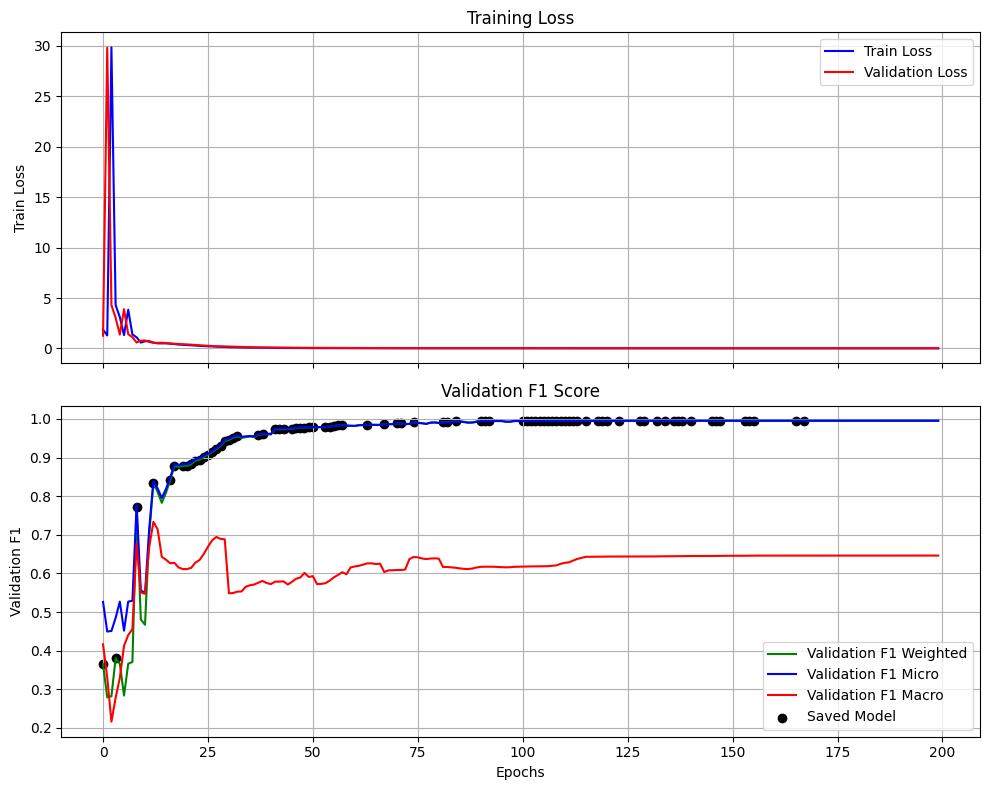

In [27]:
plot_training_process()

In [28]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    class_degree_report = {}
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        epsilon = 1e-6 # to avoid division by zero
        avg_influence = (avg_out ** 2) / ((avg_in + epsilon) * WINDOW_SIZE)
        max_influence = (max_out ** 2) / ((min_in + epsilon) * WINDOW_SIZE)
        min_influence = (min_out ** 2) / ((max_in + epsilon) * WINDOW_SIZE)

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")
        print(f"    Influence: {avg_influence:.4f} | Min: {min_influence:.4f} | Max: {max_influence:.4f}")

        class_degree_report[le.inverse_transform([cls])[0]] = {
            "avg_out": avg_out,
            "min_out": min_out,
            "max_out": max_out,
            "avg_in": avg_in,
            "min_in": min_in,
            "max_in": max_in,
            "avg_influence": avg_influence,
            "min_influence": min_influence,
            "max_influence": max_influence
        }

    return class_degree_report

class_degree_report = check_global_avg_degrees_per_class(test_graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 1.0026 | Min: 1 | Max: 160
    Avg In-Degree (dst): 253.2233 | Min: 1 | Max: 750
    Influence: 0.0000 | Min: 0.0000 | Max: 34.1333
  Attack Class ['DoS']:
    Avg Out-Degree (src): 1.0002 | Min: 1 | Max: 32
    Avg In-Degree (dst): 231.9897 | Min: 1 | Max: 750
    Influence: 0.0000 | Min: 0.0000 | Max: 1.3653
  Attack Class ['Normal']:
    Avg Out-Degree (src): 1.0349 | Min: 1 | Max: 2
    Avg In-Degree (dst): 2.0460 | Min: 1 | Max: 17
    Influence: 0.0007 | Min: 0.0001 | Max: 0.0053
  Attack Class ['Reconnaissance']:
    Avg Out-Degree (src): 5.7721 | Min: 1 | Max: 750
    Avg In-Degree (dst): 1.2944 | Min: 1 | Max: 744
    Influence: 0.0343 | Min: 0.0000 | Max: 749.9993


In [29]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    # Check if dataset is a list of (data, label) tuples or just data objects
    if isinstance(dataset[0], (list, tuple)):
        data_obj = dataset[0][0]
    else:
        data_obj = dataset[0]

    num_features = data_obj.edge_attr.shape[1]
    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=len(class_map)).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)

    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)
    
    return classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, output_dict=True, labels=range(len(class_map)))


print("Number of test graphs: ", len(test_graph_dataset))
normal_report = eval(test_graph_dataset)


Number of test graphs:  733
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.9949
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[286893   2272      6     10      0]
 [   319 246746      2      2      0]
 [     0     51    122      5      0]
 [    59     86      9  13168      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9987    0.9921    0.9954    289181
           DoS     0.9903    0.9987    0.9945    247069
        Normal     0.8777    0.6854    0.7697       178
Reconnaissance     0.9987    0.9884    0.9935     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9949    549750
     macro avg     0.7731    0.7329    0.7506    549750
  weighted avg     0.9949    0.9949    0.9949    549750



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [30]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_node_type='both', random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    if to_node_type == 'src':
         to_nodes = edge_index[0]

    elif to_node_type == 'dst':
         to_nodes = edge_index[1]

    elif to_node_type == 'both':
         to_nodes = th.cat([edge_index[0], edge_index[1]])

    else:
        raise ValueError("to_node_type must be 'src', 'dst', or 'both'.")

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []
    
    for i in range(num_to_inject):
        rng = random.Random(random_seed + i)  # ensure different seed per iteration
        src = rng.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = rng.choice(to_nodes.tolist())  # to existing nodes

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [31]:
# Inject Attack Traffic to Attacker Nodes
inject_both_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='both') for g in test_graph_dataset]
inject_both_report = eval(inject_both_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8723
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [15534 13074   582 25784     1     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[287503   1452     23    203      0]
 [  9303 235904    221   1641      0]
 [     0     44    127      7      0]
 [    25      5   9353   3939      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9686    0.9942    0.9812    289181
           DoS     0.9937    0.9548    0.9739    247069
        Normal     0.0131    0.7135    0.0257       178
Reconnaissance     0.6803    0.2957    0.4122     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9595    549750
     macro avg     0.5311    0.5916    0.4786    549750
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [32]:
# Inject Attack Traffic to Attacker Nodes
inject_src_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='src') for g in test_graph_dataset]
inject_src_report = eval(inject_src_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8611
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [  100     4   217 54654     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[286888   2056     71    166      0]
 [ 13029 230469    721   2850      0]
 [     1     46    127      4      0]
 [    20      4  10028   3270      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9565    0.9921    0.9740    289181
           DoS     0.9909    0.9328    0.9610    247069
        Normal     0.0116    0.7135    0.0228       178
Reconnaissance     0.5199    0.2455    0.3335     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9473    549750
     macro avg     0.4958    0.5768    0.4583    549750
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [33]:
# Inject Attack Traffic to Attacker Nodes
inject_dst_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='dst') for g in test_graph_dataset]
inject_dst_report = eval(inject_dst_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8831
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [29223 23438    55  2258     1     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[287641   1519      5     16      0]
 [  5047 233078      2   8942      0]
 [     0     49    122      7      0]
 [    49     78     10  13185      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9826    0.9947    0.9886    289181
           DoS     0.9930    0.9434    0.9675    247069
        Normal     0.8777    0.6854    0.7697       178
Reconnaissance     0.5953    0.9897    0.7434     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9714    549750
     macro avg     0.6897    0.7226    0.6939    549750
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [34]:
# Edge Attribute Perturbation
def perturb_edge_attributes(graph, affected_edge_ratio=0.1, perturbation_ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()

    num_edges = edge_index.size(1)
    feature_dim = edge_attr.size(1)

    # Randomly select edges to perturb
    num_to_perturb = max(1, int(affected_edge_ratio * num_edges))
    rng = random.Random(random_seed)
    indices_to_perturb = rng.sample(range(num_edges), num_to_perturb)

    for idx in indices_to_perturb:
        # Perturb the edge attributes by adding noise
        noise = th.randn(feature_dim) * perturbation_ratio  # Adjust the scale of noise as needed
        edge_attr[idx] += noise

    # Create a new graph with perturbed attributes
    perturbed_graph = Data(edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label, x=graph.x)

    return perturbed_graph

In [35]:
# Edge Attribute Perturbation
edge_perturb_graph_dataset = [perturb_edge_attributes(g.cpu(), affected_edge_ratio=1, perturbation_ratio=5) for g in test_graph_dataset]
edge_perturb_report = eval(edge_perturb_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.8255
Adversarial confusion matrix: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[254867  30168    190   3953      3]
 [ 34787 192658   3907  15682     35]
 [    11     17    135     15      0]
 [  1739   2157   2939   6173    314]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.8746    0.8813    0.8780    289181
           DoS     0.8563    0.7798    0.8162    247069
        Normal     0.0188    0.7584    0.0367       178
Reconnaissance     0.2391    0.4634    0.3154     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.8255    549750
     macro avg     0.3978    0.5766    0.4093    549750
  weighted avg     0.8507    0.8255    0.8363    549750



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for i in range(num_injected_edges):
        rng = random.Random(random_seed + i)  # ensure different seed per edge
        src = rng.randint(0, num_nodes - 1)  # Random source node
        dst = rng.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [37]:
# Inject Random Edges
random_edge_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
random_edge_report = eval(random_edge_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_endpoint_750/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.8754
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [   29    78  3424 51443     1     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[286018   2059    930    174      0]
 [ 12145 230823   1619   2482      0]
 [     0     45    123      8      2]
 [    64     79    760  12419      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9591    0.9891    0.9738    289181
           DoS     0.9906    0.9342    0.9616    247069
        Normal     0.0358    0.6910    0.0681       178
Reconnaissance     0.8234    0.9322    0.8744     13322
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9630    549750
     macro avg     0.5618    0.7093    0.5756    549750
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
def compare_overall_metrics(baseline_report, adversarial_reports, class_degree_report):
    rows = []   
    metrics = ['precision', 'recall', 'f1-score']
    eplison = 1e-10  # To avoid division by zero

    for label in list(class_map) + ['macro avg', 'weighted avg']:
        row = {"Class": label}
        row['Class'] = label
        row['Min Influence'] = class_degree_report[label]['min_influence'] if label in class_degree_report else 0.0
        row['Avg Influence'] = class_degree_report[label]['avg_influence'] if label in class_degree_report else 0.0
        row['Max Influence'] = class_degree_report[label]['max_influence'] if label in class_degree_report else 0.0
        for metric in metrics:
            baseline_val = baseline_report[label][metric]
            row[f"Normal {metric}"] = baseline_val
            for name, report in adversarial_reports.items():
                adv_val = report[label][metric]
                row[f"{name} {metric}"] = adv_val
                row[f"{name} {metric} Drop (%)"] = ((baseline_val - adv_val) / (baseline_val + eplison)) * 100
        row['support'] = int(baseline_report[label]['support'])
        rows.append(row)

    return pd.DataFrame(rows)

adversarial_reports = {
    "To Both": inject_both_report,
    "To Src": inject_src_report,
    "To Dst": inject_dst_report,
    "Edge Perturbation": edge_perturb_report,
    "Random Edge": random_edge_report,
}

comparison_df = compare_overall_metrics(normal_report, adversarial_reports, class_degree_report)

class_col = comparison_df['Class']
support_df = comparison_df['support']
normal_cols = [col for col in comparison_df.columns if col.startswith('Normal')] 
influence_cols = [col for col in comparison_df.columns if col.endswith('Influence')] 
influence_df = comparison_df[influence_cols]
f1_cols = [col for col in comparison_df.columns if col.endswith('f1-score')]
f1_drop_cols = [col for col in comparison_df.columns if col.endswith('f1-score Drop (%)')]

baselines_df = pd.concat([class_col, support_df, influence_df], axis=1)

f1_df = pd.concat([baselines_df, comparison_df[f1_cols]], axis=1)
f1_drop_df = pd.concat([baselines_df, comparison_df[f1_drop_cols]], axis=1)

print("Comparison of Overall Metrics:")
display(comparison_df.style.set_caption("Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))


Comparison of Overall Metrics:


,Class,Min Influence,Avg Influence,Max Influence,Normal precision,To Both precision,To Both precision Drop (%),To Src precision,To Src precision Drop (%),To Dst precision,To Dst precision Drop (%),Edge Perturbation precision,Edge Perturbation precision Drop (%),Random Edge precision,Random Edge precision Drop (%),Normal recall,To Both recall,To Both recall Drop (%),To Src recall,To Src recall Drop (%),To Dst recall,To Dst recall Drop (%),Edge Perturbation recall,Edge Perturbation recall Drop (%),Random Edge recall,Random Edge recall Drop (%),Normal f1-score,To Both f1-score,To Both f1-score Drop (%),To Src f1-score,To Src f1-score Drop (%),To Dst f1-score,To Dst f1-score Drop (%),Edge Perturbation f1-score,Edge Perturbation f1-score Drop (%),Random Edge f1-score,Random Edge f1-score Drop (%),support
0,DDoS,0.00,0.00,34.13,1.00,0.97,3.01,0.96,4.22,0.98,1.61,0.87,12.42,0.96,3.97,0.99,0.99,-0.21,0.99,0.00,0.99,-0.26,0.88,11.16,0.99,0.30,1.00,0.98,1.42,0.97,2.15,0.99,0.68,0.88,11.80,0.97,2.16,289181
1,DoS,0.00,0.00,1.37,0.99,0.99,-0.34,0.99,-0.06,0.99,-0.27,0.86,13.54,0.99,-0.03,1.00,0.95,4.39,0.93,6.60,0.94,5.54,0.78,21.92,0.93,6.45,0.99,0.97,2.08,0.96,3.37,0.97,2.71,0.82,17.93,0.96,3.31,247069
2,Normal,0.00,0.00,0.01,0.88,0.01,98.51,0.01,98.68,0.88,0.00,0.02,97.86,0.04,95.92,0.69,0.71,-4.10,0.71,-4.10,0.69,0.00,0.76,-10.66,0.69,-0.82,0.77,0.03,96.67,0.02,97.03,0.77,0.00,0.04,95.23,0.07,91.15,178
3,Reconnaissance,0.00,0.03,750.00,1.00,0.68,31.88,0.52,47.95,0.60,40.40,0.24,76.06,0.82,17.56,0.99,0.30,70.09,0.25,75.17,0.99,-0.13,0.46,53.12,0.93,5.69,0.99,0.41,58.51,0.33,66.44,0.74,25.18,0.32,68.26,0.87,11.99,13322
4,Theft,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
5,macro avg,0.00,0.00,0.00,0.77,0.53,31.30,0.50,35.87,0.69,10.79,0.40,48.55,0.56,27.33,0.73,0.59,19.28,0.58,21.31,0.72,1.40,0.58,21.33,0.71,3.22,0.75,0.48,36.24,0.46,38.95,0.69,7.56,0.41,45.48,0.58,23.32,549750
6,weighted avg,0.00,0.00,0.00,0.99,0.97,2.24,0.96,3.40,0.98,1.71,0.85,14.49,0.97,2.54,0.99,0.96,3.56,0.95,4.79,0.97,2.36,0.83,17.02,0.96,3.21,0.99,0.96,3.12,0.95,4.28,0.97,2.19,0.84,15.94,0.97,2.94,549750


In [39]:
# Check F1 Scores
display(f1_df.style.background_gradient(cmap='Greens', subset=f1_cols, axis=0).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,Normal f1-score,To Both f1-score,To Src f1-score,To Dst f1-score,Edge Perturbation f1-score,Random Edge f1-score
0,DDoS,289181,0.00,0.00,34.13,1.00,0.98,0.97,0.99,0.88,0.97
1,DoS,247069,0.00,0.00,1.37,0.99,0.97,0.96,0.97,0.82,0.96
2,Normal,178,0.00,0.00,0.01,0.77,0.03,0.02,0.77,0.04,0.07
3,Reconnaissance,13322,0.00,0.03,750.00,0.99,0.41,0.33,0.74,0.32,0.87
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,549750,0.00,0.00,0.00,0.75,0.48,0.46,0.69,0.41,0.58
6,weighted avg,549750,0.00,0.00,0.00,0.99,0.96,0.95,0.97,0.84,0.97


In [40]:
# Compare Drops per Adversarial Attack
display(f1_drop_df[f1_drop_df['Class'] == 'weighted avg'].style.background_gradient(cmap='Reds', subset=f1_drop_cols, axis=None).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
6,weighted avg,549750,0.00,0.00,0.00,3.12,4.28,2.19,15.94,2.94


In [41]:
# Compare Drops per Class
display(f1_drop_df.style.background_gradient(cmap='Reds', subset=f1_drop_cols).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
0,DDoS,289181,0.00,0.00,34.13,1.42,2.15,0.68,11.80,2.16
1,DoS,247069,0.00,0.00,1.37,2.08,3.37,2.71,17.93,3.31
2,Normal,178,0.00,0.00,0.01,96.67,97.03,0.00,95.23,91.15
3,Reconnaissance,13322,0.00,0.03,750.00,58.51,66.44,25.18,68.26,11.99
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,549750,0.00,0.00,0.00,36.24,38.95,7.56,45.48,23.32
6,weighted avg,549750,0.00,0.00,0.00,3.12,4.28,2.19,15.94,2.94


In [42]:
from collections import defaultdict
from pprint import pformat

def round_tuple(t):
    return tuple(round(x, 2) for x in t)

def print_results(class_degree_report, comparison_df):
    report_dict = defaultdict(dict)

    for class_name, metrics in class_degree_report.items():
        report_dict[class_name] = {
            "influence": round_tuple((metrics['min_influence'], metrics['avg_influence'], metrics['max_influence'])),
            "out_degree": round_tuple((metrics['min_out'], metrics['avg_out'], metrics['max_out'])),
            "in_degree": round_tuple((metrics['min_in'], metrics['avg_in'], metrics['max_in']))
        }

    for _, row in comparison_df.iterrows():
        class_name = row['Class']
        if class_name == 'weighted avg':
            class_name = 'Weighted Average'
        report_dict[class_name].update({
            "normal_f1": round(row['Normal f1-score'], 2),
            "to_both_f1": round(row['To Both f1-score'], 2),
            "to_src_f1": round(row['To Src f1-score'], 2),
            "to_dst_f1": round(row['To Dst f1-score'], 2),
            "edge_perturb_f1": round(row['Edge Perturbation f1-score'], 2),
            "random_edge_f1": round(row['Random Edge f1-score'], 2),
        })

    print(pformat(dict(report_dict), sort_dicts=False, indent=1))

print_results(class_degree_report, comparison_df)

{'DDoS': {'influence': (0.0, 0.0, 34.13),
          'out_degree': (1.0, 1.0, 160.0),
          'in_degree': (1.0, 253.22, 750.0),
          'normal_f1': 1.0,
          'to_both_f1': 0.98,
          'to_src_f1': 0.97,
          'to_dst_f1': 0.99,
          'edge_perturb_f1': 0.88,
          'random_edge_f1': 0.97},
 'DoS': {'influence': (0.0, 0.0, 1.37),
         'out_degree': (1.0, 1.0, 32.0),
         'in_degree': (1.0, 231.99, 750.0),
         'normal_f1': 0.99,
         'to_both_f1': 0.97,
         'to_src_f1': 0.96,
         'to_dst_f1': 0.97,
         'edge_perturb_f1': 0.82,
         'random_edge_f1': 0.96},
 'Normal': {'influence': (0.0, 0.0, 0.01),
            'out_degree': (1.0, 1.03, 2.0),
            'in_degree': (1.0, 2.05, 17.0),
            'normal_f1': 0.77,
            'to_both_f1': 0.03,
            'to_src_f1': 0.02,
            'to_dst_f1': 0.77,
            'edge_perturb_f1': 0.04,
            'random_edge_f1': 0.07},
 'Reconnaissance': {'influence': (0.0, 0.03, 750